In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

class VelocityField(nn.Module):
    def __init__(self, x_dim, cond_dim, hidden_dim=128, time_embed_dim=16):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.freqs = nn.Parameter(torch.linspace(1.0, 10.0, time_embed_dim), requires_grad=False)

        input_dim = x_dim + time_embed_dim + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, x_dim)
        )

    def time_embed(self, t):
        return torch.sin(t * self.freqs)

    def forward(self, x_t, t, y):
        """
        x_t: [B, d]  -- interpolated state
        t:   [B, 1]  -- scalar time
        y:   [B, c]  -- conditional input
        """
        t_embed = self.time_embed(t)  # [B, time_embed_dim]
        h = torch.cat([x_t, t_embed, y], dim=-1)
        return self.net(h)  # [B, d]

def flow_matching_loss(model, x0, x1, y):
    """
    x0, x1: [B, d]   -- samples from conditional marginal
    y:     [B, c]   -- conditioning variable
    """
    B, d = x0.shape
    t = torch.rand(B, 1, device=x0.device)
    x_t = (1 - t) * x0 + t * x1
    v_target = x1 - x0

    v_pred = model(x_t, t, y)
    return F.mse_loss(v_pred, v_target)


In [175]:
def rk4_step(f, x, t, dt, y):
    """Performs one RK4 step for dx/dt = f(t, x) with conditioning y"""
    k1 = f(t,     x,     y)
    k2 = f(t+dt/2, x + dt/2 * k1, y)
    k3 = f(t+dt/2, x + dt/2 * k2, y)
    k4 = f(t+dt,   x + dt   * k3, y)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_integrate(f, x0, t0, t1, y, steps=100):
    """
    Integrate dx/dt = f(t, x, y) from t0 to t1 using RK4

    Args:
        f: function f(t, x, y) -> dx/dt
        x0: [B, d] initial state
        t0: float
        t1: float
        y: [B, cond_dim] conditioning
        steps: number of steps to integrate

    Returns:
        x_T: final state at t1
    """
    dt = (t1 - t0) / steps
    x = x0
    t = t0
    for _ in range(steps):
        x = rk4_step(f, x, t, dt, y)
        t += dt
    return x

def velocity_wrapper(model):
    """
    Returns a callable f(t, x, y) to integrate with RK4
    """
    def f(t, x, y):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        B = x.shape[0]
        t_tensor = torch.ones(B, 1, device=x.device) * t
        return model(x, t_tensor, y)
    return f

@torch.no_grad()
def sample_from_flow(model, x0, y, t0=0.0, t1=1.0, steps=100):
    f = velocity_wrapper(model)
    return rk4_integrate(f, x0, t0, t1, y, steps)


In [183]:
class ConvVelocityField(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, time_embed_dim=16):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.freqs = nn.Parameter(torch.linspace(1.0, 10.0, time_embed_dim), requires_grad=False)

        # Project time embedding to match spatial resolution
        self.time_proj = nn.Linear(time_embed_dim, hidden_channels)

        # Conv net
        self.net = nn.Sequential(
            nn.Conv2d(in_channels + hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(hidden_channels, in_channels, kernel_size=3, padding=1)
        )

    def time_embed(self, t):
        # t: [B, 1]
        return torch.sin(t * self.freqs)  # [B, time_embed_dim]

    def forward(self, x_t, t):
        """
        x_t: [B, C, H, W]  -- interpolated state
        t:   [B, 1]        -- scalar time
        """
        # Create time embedding
        t_embed = self.time_embed(t)  # [B, time_embed_dim]
        t_proj = self.time_proj(t_embed)  # [B, hidden_channels]
        # Broadcast to spatial dims
        t_proj = t_proj[:, :, None, None].expand(-1, -1, x_t.shape[2], x_t.shape[3])

        # Concatenate time conditioning
        h = torch.cat([x_t, t_proj], dim=1)  # [B, C+hidden_channels, H, W]
        return self.net(h)  # [B, C, H, W]

In [173]:
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------------------------------------------------
# Small helpers: time embedding and residual block that accepts time
# ---------------------------------------------------------------------
class TimeEmbed(nn.Module):
    def __init__(self, time_embed_dim=16, hidden_dim=128):
        super().__init__()
        # fixed freqs as in your original code (not learned)
        self.freqs = nn.Parameter(torch.linspace(1.0, 10.0, time_embed_dim), requires_grad=False)
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, t):
        # t: [B, 1]
        # produces [B, hidden_dim]
        x = torch.sin(t * self.freqs)  # [B, time_embed_dim]
        return self.mlp(x)


class ResConvBlock(nn.Module):
    """
    Residual conv block which adds a (broadcasted) time embedding after first conv.
    """
    def __init__(self, in_ch, out_ch, time_dim, groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(groups, out_ch)
        self.time_proj = nn.Linear(time_dim, out_ch)

        # if channel mismatch, use 1x1 to match for residual
        self.nin_shortcut = nn.Identity()
        if in_ch != out_ch:
            self.nin_shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x, t_emb):
        """
        x: [B, C, H, W]
        t_emb: [B, time_dim]
        """
        h = self.conv1(x)
        # add time embedding (project & broadcast)
        t = self.time_proj(t_emb)[:, :, None, None]
        h = self.gn1(h + t)
        h = F.silu(h)

        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)

        return h + self.nin_shortcut(x)


# ---------------------------------------------------------------------
# U-Net velocity field
# ---------------------------------------------------------------------
class ConvUNetVelocityField(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, time_embed_dim=16, time_mlp_dim=128, depths=(1, 1, 2)):
        """
        - in_channels: image channels (1 for MNIST, 3 for CIFAR)
        - base_channels: number of channels in the first stage
        - time_embed_dim: size of the sinusoidal frequency embedding
        - time_mlp_dim: hidden dim for time MLP (injected into ResConvBlock)
        - depths: tuple controlling number of ResConvBlocks per stage (down / bottleneck / up)
        """
        super().__init__()
        self.time_mlp = TimeEmbed(time_embed_dim=time_embed_dim, hidden_dim=time_mlp_dim)

        # Encoder stages
        self.enc_blocks = nn.ModuleList()
        self.downs = nn.ModuleList()
        in_ch = in_channels
        channels = []
        for i, d in enumerate(depths):
            out_ch = base_channels * (2 ** i)
            for _ in range(d):
                self.enc_blocks.append(ResConvBlock(in_ch, out_ch, time_dim=time_mlp_dim))
                in_ch = out_ch
            channels.append(out_ch)
            # downsample between stages (except after last)
            self.downs.append(nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1))  # halves H,W

        # Bottleneck (an extra block)
        self.bot_block = ResConvBlock(in_ch, in_ch * 2, time_dim=time_mlp_dim)
        bot_ch = in_ch * 2

        # Decoder stages (mirror)
        self.up_convs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        rev_channels = list(reversed(channels))
        in_ch = bot_ch
        for i, out_ch in enumerate(rev_channels):
            # upsample via ConvTranspose2d to double spatial dims
            self.up_convs.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))
            # After concatenation with skip, process with ResConvBlock(s)
            self.dec_blocks.append(ResConvBlock(in_ch=out_ch * 2, out_ch=out_ch, time_dim=time_mlp_dim))
            in_ch = out_ch

        # final conv to map back to image channels
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x_t, t):
        """
        x_t: [B, C, H, W]
        t:   [B, 1]  (scalar time per sample)
        returns velocity of same shape as x_t: [B, C, H, W]
        """
        B, C, H, W = x_t.shape
        t_emb = self.time_mlp(t)  # [B, time_mlp_dim]

        # Encoder: store skips
        skips = []
        idx = 0
        h = x_t
        # iterate over enc_blocks and downs; enc_blocks is flattened sequence
        enc_block_iter = iter(self.enc_blocks)
        for down in self.downs:
            # each stage may have multiple blocks (depending on how many were appended)
            # We find blocks until next down is consumed (we appended d blocks per stage)
            # Implementation detail: we rely on the ordering used during creation
            # Apply the number of blocks that correspond to this stage by applying blocks until shape changes from down op
            # Simpler: apply one block per stage loop per depths value; earlier we stored "depths"
            # But to keep logic simple and robust, we apply blocks until the next down is applied.
            # Here we just apply one block per downs stage (matching how we built enc_blocks).
            block = next(enc_block_iter)
            h = block(h, t_emb)
            skips.append(h)
            h = down(h)

        # There may be remaining enc_blocks if depths had >1 in a stage; consume them
        for block in enc_block_iter:
            h = block(h, t_emb)

        # Bottleneck
        h = self.bot_block(h, t_emb)

        # Decoder: upsample and use skips
        for up_conv, dec_block in zip(self.up_convs, self.dec_blocks):
            h = up_conv(h)
            skip = skips.pop()  # last skip
            # If shapes differ by 1 due to odd sizes, center-crop skip to match
            if skip.shape[-2:] != h.shape[-2:]:
                # simple center crop
                sh, sw = skip.shape[-2:]
                hh, ww = h.shape[-2:]
                start_h = (sh - hh) // 2
                start_w = (sw - ww) // 2
                skip = skip[..., start_h:start_h+hh, start_w:start_w+ww]
            # concat channels
            h = torch.cat([h, skip], dim=1)
            h = dec_block(h, t_emb)

        # final conv
        v = self.final_conv(h)
        v = nn.Upsample((28, 28))(v)
        return v

In [55]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Download and load the training dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Download and load the test dataset
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# # Example: iterate over the training data
# for batch_idx, (x, y) in enumerate(train_loader):
#     print(f"Batch {batch_idx} | Data shape: {x.shape} | Target shape: {y.shape}")
#     break

In [56]:
model = ConvUNetVelocityField(in_channels=1, base_channels=64, time_embed_dim=16, time_mlp_dim=128, depths=(1,1,2))

In [57]:
t = torch.rand(64, 1)
v = model(x, t)
v.shape

torch.Size([64, 1, 28, 28])

In [61]:
# Example: iterate over the training data
model = ConvUNetVelocityField(in_channels=1, base_channels=64, time_embed_dim=16, time_mlp_dim=128, depths=(1,1,2))
for x, y in train_loader:
    pass

In [63]:
def conv_flow_matching_loss(model, x0, x1):
    """
    x0, x1: [B, d]   -- samples from conditional marginal
    y:     [B, c]   -- conditioning variable
    """
    n, c, h, w = x0.shape
    t = torch.rand(n, 1, device=x0.device)
    t_conv = t[:,:,None,None]
    x_t = (1 - t_conv) * x0 + t_conv * x1
    v_target = x1 - x0
    v_pred = model(x_t, t)
    return F.mse_loss(v_pred, v_target)

In [179]:
def gradient_field_penalty(v_func, x, t, num_samples=1, sym_weight=1.0, eig_weight=1.0):
    """
    Computes a regularization penalty to encourage v ≈ ∇φ (gradient of convex potential)

    v_func: velocity model, takes (x, t, y) -> [B, D]
    x: [B, D], requires_grad=True
    t: [B, 1]
    y: [B, C]
    Returns:
        scalar penalty
    """
    # B, D = x.shape
    n, c, h, w = x.shape
    device = x.device
    penalty = 0.0

    for _ in range(num_samples):
        z = torch.randn_like(x)  # Hutchinson probe

        # Vector-Jacobian product: J_v z
        v = v_func(x, t)  # [B, D]
        Jv_z = torch.autograd.grad(
            outputs=v,
            inputs=x,
            grad_outputs=z,
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]  # [B, D]

        # Jacobian-Vector product: J_v^T z = ∇_x (v^T z)
        vz = torch.sum(v * z, dim=1)  # [B]
        JvT_z = torch.autograd.grad(
            outputs=vz,
            inputs=x,
            grad_outputs=torch.ones_like(vz),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]  # [B, D]

        # Symmetry penalty: || Jv_z - JvT_z ||^2
        sym_penalty = ((Jv_z - JvT_z)**2).sum(dim=1)  # [B]

        # Convexity (PSD) penalty: penalize z^T Jv z < 0
        zT_Jv_z = (Jv_z * z).sum(dim=1)  # [B]
        eig_penalty = F.relu(-zT_Jv_z)**2  # [B]

        penalty += sym_weight * sym_penalty.mean() + eig_weight * eig_penalty.mean()

    return penalty / num_samples

def CGM_loss(model, x0, x1, reg_weight=1.0, sym_weight=1.0, eig_weight=1.0):
    n, c, h, w = x0.shape
    t = torch.rand(n, 1, device=x0.device)
    t_conv = t[:,:,None,None]
    x_t = (1 - t_conv) * x0 + t_conv * x1
    x_t = x_t.detach().requires_grad_()
    v_target = x1 - x0
    v_pred = model(x_t, t)
    
    fm_loss = F.mse_loss(v_pred, v_target)
    reg_penalty = gradient_field_penalty(model, x_t, t,sym_weight=sym_weight, eig_weight=eig_weight)

    return fm_loss + reg_weight * reg_penalty, {
        'fm_loss': fm_loss.item(),
        'reg_penalty': reg_penalty.item()
    }

def add_sgmcmc_noise(model, lr, noise_scale=1.0):
    for p in model.parameters():
        if p.grad is None:
            continue
        noise = torch.randn_like(p) * torch.sqrt(torch.tensor(2.0 * lr)) * noise_scale
        p.data.add_(noise)

In [180]:
def rk4_step(f, x, t, dt):
    """Performs one RK4 step for dx/dt = f(t, x) with conditioning y"""
    k1 = f(t,     x)
    k2 = f(t+dt/2, x + dt/2 * k1)
    k3 = f(t+dt/2, x + dt/2 * k2)
    k4 = f(t+dt,   x + dt   * k3)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

def rk4_integrate(f, x0, t0, t1,steps=100):
    """
    Integrate dx/dt = f(t, x, y) from t0 to t1 using RK4

    Args:
        f: function f(t, x, y) -> dx/dt
        x0: [B, d] initial state
        t0: float
        t1: float
        y: [B, cond_dim] conditioning
        steps: number of steps to integrate

    Returns:
        x_T: final state at t1
    """
    dt = (t1 - t0) / steps
    x = x0
    t = t0
    for _ in range(steps):
        x = rk4_step(f, x, t, dt)
        t += dt
    return x

def velocity_wrapper(model):
    """
    Returns a callable f(t, x, y) to integrate with RK4
    """
    def f(t, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        B = x.shape[0]
        t_tensor = torch.ones(B, 1, device=x.device) * t
        return model(x, t_tensor)
    return f

@torch.no_grad()
def sample_from_flow(model, x0, t0=0.0, t1=1.0, steps=100):
    f = velocity_wrapper(model)
    return rk4_integrate(f, x0, t0, t1, steps)


In [155]:
# conv_flow_matching_loss(model, torch.randn_like(x), x)

In [156]:
from tqdm.notebook import trange, tqdm

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [158]:
lr = 1e-3
model = ConvUNetVelocityField(in_channels=1, base_channels=64, time_embed_dim=16, time_mlp_dim=128, depths=(1,1,2))
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(10):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = conv_flow_matching_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())
      # add_sgmcmc_noise(model, lr=lr, noise_scale=1e-3)k += 1


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.6665, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.6441, device='cuda:0')
tensor(0.5946, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.6087, device='cuda:0')
tensor(0.6145, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5943, device='cuda:0')
tensor(0.6073, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5881, device='cuda:0')
tensor(0.5584, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5848, device='cuda:0')
tensor(0.5803, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5481, device='cuda:0')
tensor(0.5901, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5564, device='cuda:0')
tensor(0.5813, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5759, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.5780, device='cuda:0')
tensor(0.5476, device='cuda:0')


In [159]:
def sgmcmc_sample(model, lr, noise_scale=1.0):
  import copy
  model_samp = copy.deepcopy(model)
  for p in model_samp.parameters():
    noise = torch.randn_like(p) * torch.sqrt(torch.tensor(2.0 * lr)) * noise_scale
    p.data.add_(noise)
  return model_samp

In [111]:
# lr = 1e-3

# model_samp = sgmcmc_sample(model, lr, noise_scale=1.0)
# x1_samp1 = sample_from_flow(model_samp, torch.randn(1000, 1), 0*torch.randn(1000, 1))

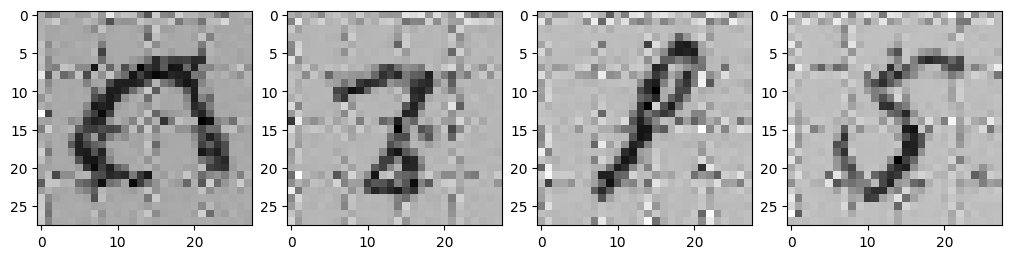

In [166]:
x1_samp = sample_from_flow(model, torch.randn_like(x1).cuda())

fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(x1_samp[0,0].cpu(), cmap = 'binary')
ax[1].imshow(x1_samp[1,0].cpu(), cmap = 'binary')
ax[2].imshow(x1_samp[2,0].cpu(), cmap = 'binary')
ax[3].imshow(x1_samp[3,0].cpu(), cmap = 'binary')
plt.show()

In [189]:
lr = 1e-3
model = ConvVelocityField(in_channels=1, hidden_channels=128, time_embed_dim=64)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(25):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = conv_flow_matching_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())
      # add_sgmcmc_noise(model, lr=lr, noise_scale=1e-3)k += 1

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3902, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3480, device='cuda:0')
tensor(0.3313, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3202, device='cuda:0')
tensor(0.3403, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3126, device='cuda:0')
tensor(0.3571, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2889, device='cuda:0')
tensor(0.2792, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3739, device='cuda:0')
tensor(0.3253, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2921, device='cuda:0')
tensor(0.2648, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3264, device='cuda:0')
tensor(0.2874, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3321, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3225, device='cuda:0')
tensor(0.3268, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.2913, device='cuda:0')
tensor(0.3229, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3039, device='cuda:0')
tensor(0.4272, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3166, device='cuda:0')
tensor(0.3244, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3129, device='cuda:0')
tensor(0.3114, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3299, device='cuda:0')
tensor(1.9206, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(2.0195, device='cuda:0')


KeyboardInterrupt: 

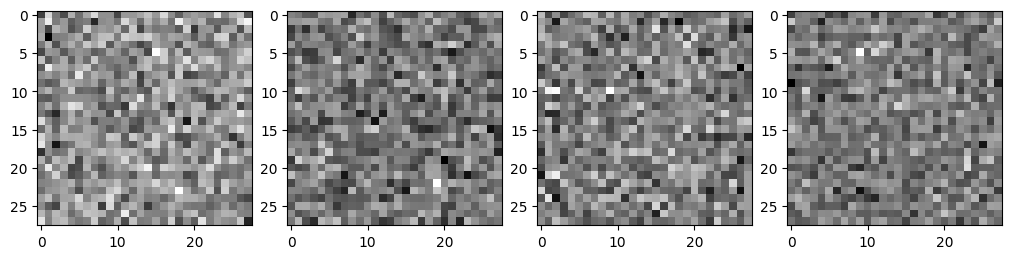

In [190]:
x1_samp = sample_from_flow(model, torch.randn_like(x1).cuda())

fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(x1_samp[0,0].cpu(), cmap = 'binary')
ax[1].imshow(x1_samp[1,0].cpu(), cmap = 'binary')
ax[2].imshow(x1_samp[2,0].cpu(), cmap = 'binary')
ax[3].imshow(x1_samp[3,0].cpu(), cmap = 'binary')
plt.show()

In [319]:
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Spectral conv (custom FNO)
# -------------------------
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.weight_real = nn.Parameter(
            torch.randn(in_channels, out_channels, modes1, modes2) * 0.01
        )
        self.weight_imag = nn.Parameter(
            torch.randn(in_channels, out_channels, modes1, modes2) * 0.01
        )

    def compl_mul2d(self, input_ft, w_real, w_imag):
        weight = torch.complex(w_real, w_imag)
        return torch.einsum("bixy,ioxy->boxy", input_ft, weight)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")
        out_ft = torch.zeros(B, self.out_channels, H, W//2 + 1, dtype=torch.cfloat, device=x.device)

        m1 = min(self.modes1, H)
        m2 = min(self.modes2, W//2 + 1)
        out_ft[:, :, :m1, :m2] = self.compl_mul2d(
            x_ft[:, :, :m1, :m2],
            self.weight_real[:, :, :m1, :m2],
            self.weight_imag[:, :, :m1, :m2]
        )

        x_out = torch.fft.irfft2(out_ft, s=(H, W), norm="ortho")
        return x_out

# -------------------------
# Time embedding
# -------------------------
class TimeEmbed(nn.Module):
    def __init__(self, time_embed_dim=16, hidden_dim=64):
        super().__init__()
        self.freqs = nn.Parameter(torch.linspace(1.0, 10.0, time_embed_dim), requires_grad=False)
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

    def forward(self, t):
        x = torch.sin(t * self.freqs)
        return self.mlp(x)


# -------------------------
# Simple FNO block
# -------------------------
class FNOBlock(nn.Module):
    def __init__(self, in_ch, out_ch, modes1, modes2, time_dim):
        super().__init__()
        self.spectral = SpectralConv2d(in_ch, out_ch, modes1, modes2)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        self.time_proj = nn.Linear(time_dim, out_ch)
        self.norm = nn.GroupNorm(8, out_ch)
        self.shortcut = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, t_emb):
        h = self.spectral(x) + self.pointwise(x)
        h = h + self.time_proj(t_emb)[:, :, None, None]
        h = self.norm(h)
        h = F.silu(h)
        return h + self.shortcut(x)


# -------------------------
# Velocity field with stacked FNO blocks
# -------------------------
class FNOVelocityField(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, time_embed_dim=16, modes1=12, modes2=12, num_layers=4):
        super().__init__()
        self.time_mlp = TimeEmbed(time_embed_dim=time_embed_dim, hidden_dim=hidden_channels)

        layers = []
        ch = in_channels
        for i in range(num_layers):
            layers.append(FNOBlock(ch, hidden_channels, modes1, modes2, hidden_channels))
            ch = hidden_channels
        self.fno_layers = nn.ModuleList(layers)

        self.final = nn.Conv2d(hidden_channels, in_channels, kernel_size=1)

    def forward(self, x_t, t):
        t_emb = self.time_mlp(t)
        h = x_t
        for layer in self.fno_layers:
            h = layer(h, t_emb)
        return self.final(h)


In [280]:
lr = 1e-3
model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(15):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = conv_flow_matching_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4019, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4892, device='cuda:0')
tensor(0.4603, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4269, device='cuda:0')
tensor(0.3205, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3829, device='cuda:0')
tensor(0.3877, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4721, device='cuda:0')
tensor(0.4512, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3704, device='cuda:0')
tensor(0.4142, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3626, device='cuda:0')
tensor(0.3979, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4676, device='cuda:0')
tensor(0.3072, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4087, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3248, device='cuda:0')
tensor(0.3534, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3900, device='cuda:0')
tensor(0.4015, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3736, device='cuda:0')
tensor(0.3261, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3983, device='cuda:0')
tensor(0.3545, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3539, device='cuda:0')
tensor(0.3833, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.3847, device='cuda:0')
tensor(0.3289, device='cuda:0')


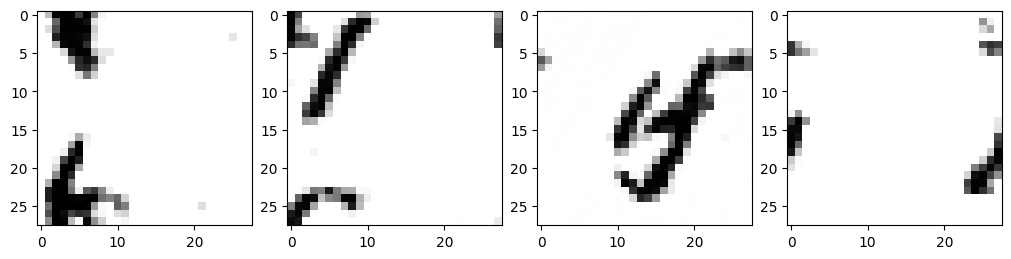

In [281]:
x1_samp = sample_from_flow(model, torch.randn_like(x1).cuda())

fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(x1_samp[0,0].cpu(), cmap = 'binary')
ax[1].imshow(x1_samp[1,0].cpu(), cmap = 'binary')
ax[2].imshow(x1_samp[2,0].cpu(), cmap = 'binary')
ax[3].imshow(x1_samp[3,0].cpu(), cmap = 'binary')
plt.show()

In [353]:
import torch.nn.functional as F

def flatten_image_batch(x):
    B, C, H, W = x.shape
    x_flat = x.view(B, -1)  # shape (B, D), D=C*H*W
    return x_flat

def unflatten_image_batch(x_flat, C, H, W):
    B = x_flat.shape[0]
    return x_flat.view(B, C, H, W)
    
def velocity_func_flat(x_flat, t, model, C, H, W):
    x = unflatten_image_batch(x_flat, C, H, W)
    v = model(x, t)  # velocity output, shape (B,C,H,W)
    v_flat = flatten_image_batch(v)
    return v_flat
from torch.autograd.functional import jvp

def jvp_velocity(x_flat, v_flat, t, model, C, H, W):
    # Computes J(x) @ v_flat
    def func(x_in):
        return velocity_func_flat(x_in, t, model, C, H, W)
    return jvp(func, (x_flat,), (v_flat,), create_graph=True)[1]

def vjp_velocity(x_flat, v_flat, t, model, C, H, W):
    # Computes J(x)^T @ v_flat
    v_out = velocity_func_flat(x_flat, t, model, C, H, W)
    grads = torch.autograd.grad(v_out, x_flat, grad_outputs=v_flat, create_graph=True, retain_graph=True)[0]
    return grads

def curl_reg(model, x_t, t, n_samples=1):
    B, C, H, W = x_t.shape
    x_flat = flatten_image_batch(x_t)
    penalty = 0.
    for _ in range(n_samples):
        z = torch.randint(0, 2, x_flat.shape, device=x_t.device).float() * 2 - 1  # Rademacher vector
        jvp_z = jvp_velocity(x_flat, z, t, model, C, H, W)
        vjp_z = vjp_velocity(x_flat, z, t, model, C, H, W)
        A_z = 0.5 * (jvp_z - vjp_z)
        penalty += (A_z ** 2).sum(dim=-1).mean()  # mean over batch
    return penalty / n_samples
    
def eigen_reg(model, x_t, t, n_samples=1):
    B, C, H, W = x_t.shape
    x_flat = flatten_image_batch(x_t)
    penalty = 0.
    for _ in range(n_samples):
        z = torch.randn_like(x_flat, device=x_flat.device)
        z = z / (z.norm(dim=-1, keepdim=True) + 1e-8)
        jvp_z = jvp_velocity(x_flat, z, t, model, C, H, W)
        rayleigh = (z * jvp_z).sum(dim=-1)
        neg_part = F.relu(-rayleigh)
        penalty += neg_part.mean()
    return penalty / n_samples

def cfm_loss(model, x_t, t, v_target):
    v_pred = model(x_t, t)
    return torch.mean((v_pred - v_target)**2)

def gradient_flow_loss(model, x0, x1, lam_curl = 1e-3, lam_eig = 1e-3, n_samples = 1):
    n, c, h, w = x0.shape
    t = torch.rand(n, 1, device=x0.device)
    t_conv = t[:,:,None,None]
    x_t = (1 - t_conv) * x0 + t_conv * x1
    x_t = x_t.detach().requires_grad_()
    v_target = x1 - x0

    loss_flow = cfm_loss(model, x_t, t, v_target)
    loss_curl = curl_reg(model, x_t, t, n_samples=n_samples)
    loss_eig = eigen_reg(model, x_t, t, n_samples=n_samples)

    return loss_flow + lam_curl * loss_curl + lam_eig * loss_eig

In [358]:
lr = 1e-3
model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for step in trange(15):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = gradient_flow_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        k += 1
        if k % 500 == 0: 
            print(loss.detach())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4164, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4576, device='cuda:0')
tensor(0.4494, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4613, device='cuda:0')
tensor(0.3587, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4275, device='cuda:0')
tensor(0.4414, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

tensor(0.4768, device='cuda:0')
tensor(0.4253, device='cuda:0')


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

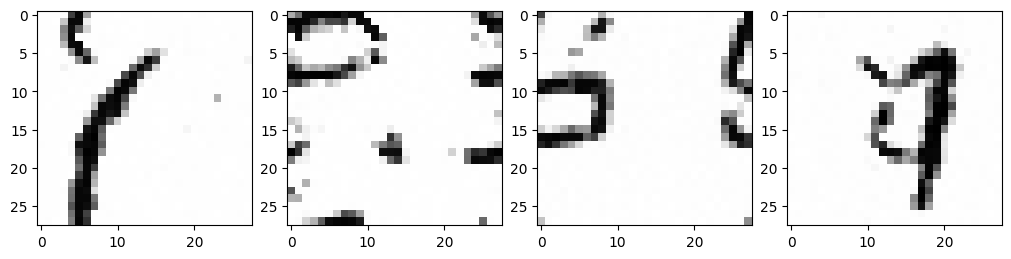

In [364]:
x1_samp = sample_from_flow(model, torch.randn_like(x1).cuda())

fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (10, 4))
ax[0].imshow(x1_samp[0,0].cpu(), cmap = 'binary')
ax[1].imshow(x1_samp[1,0].cpu(), cmap = 'binary')
ax[2].imshow(x1_samp[2,0].cpu(), cmap = 'binary')
ax[3].imshow(x1_samp[3,0].cpu(), cmap = 'binary')
plt.show()

In [302]:
import torch
from torch.autograd.functional import jvp

def jacobian_vector_product(func, x, v, create_graph=True):
    # Returns J(x) @ v
    y = func(x)
    jvp_val = jvp(func, (x,), (v,), create_graph=create_graph)[1]
    return jvp_val

def vector_jacobian_product(func, x, v, create_graph=True):
    # Returns v^T @ J(x) = J(x)^T @ v
    y = func(x)
    grads = torch.autograd.grad(y, x, grad_outputs=v, create_graph=create_graph, retain_graph=True)[0]
    return grads

def curl_penalty(func, x, n_samples=1):
    d = x.shape[-1]
    penalty = 0.
    for _ in range(n_samples):
        z = torch.randint(0, 2, x.shape, device=x.device).float() * 2 - 1  # Rademacher
        jvp_z = jacobian_vector_product(func, x, z)
        vjp_z = vector_jacobian_product(func, x, z)
        A_z = 0.5 * (jvp_z - vjp_z)
        penalty += (A_z**2).sum(dim=-1).mean()
    return penalty / n_samples

def eigenvalue_penalty(func, x, n_samples=1):
    penalty = 0.
    for _ in range(n_samples):
        z = torch.randn_like(x)
        z = z / (z.norm(dim=-1, keepdim=True) + 1e-8)
        jvp_z = jacobian_vector_product(func, x, z)
        rayleigh = (z * jvp_z).sum(dim=-1)  # batch dot product
        neg_part = F.relu(-rayleigh)  # penalize negative part only
        penalty += neg_part.mean()
    return penalty / n_samples

def ot_regularizer(func, x, n_samples=1, curl_wt=1.0, eig_wt=1.0):
    curl = curl_penalty(func, x, n_samples)
    eig = eigenvalue_penalty(func, x, n_samples)
    return curl_wt * curl + eig_wt * eig

In [303]:
lr = 1e-3
model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [304]:
ot_regularizer(model, x1)

TypeError: FNOVelocityField.forward() missing 1 required positional argument: 't'

In [292]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

class ConvICNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_hidden=True):
        super().__init__()
        # Convolution on input image with non-negative weights (softplus)
        self.conv_in = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        nn.init.uniform_(self.conv_in.weight, a=0, b=0.1)  # small positive init
        
        # Convolution on hidden state (previous layer output)
        self.use_hidden = use_hidden
        if use_hidden:
            self.conv_hidden = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=True)
            nn.init.zeros_(self.conv_hidden.bias)
        
        # FiLM scale and shift for conditioning + time
        self.film_scale = nn.Linear(128, out_channels)  # assuming cond+time embed dim=128
        self.film_shift = nn.Linear(128, out_channels)
    
    def forward(self, x_in, z_hidden, cond_emb):
        # x_in: (B, C_in, H, W)
        # z_hidden: (B, C_out, H, W) or None if first layer
        # cond_emb: (B, 128) conditioning + time embedding
        
        W_in_pos = F.softplus(self.conv_in.weight)  # enforce positivity
        
        x_term = F.conv2d(x_in, W_in_pos, bias=None, stride=self.conv_in.stride, padding=self.conv_in.padding)
        
        if self.use_hidden:
            z_term = self.conv_hidden(z_hidden)
            out = x_term + z_term
        else:
            out = x_term
        
        # Apply FiLM conditioning
        scale = self.film_scale(cond_emb).unsqueeze(-1).unsqueeze(-1)  # (B,C_out,1,1)
        shift = self.film_shift(cond_emb).unsqueeze(-1).unsqueeze(-1)
        out = out * scale + shift
        
        return F.relu(out)


class ConvConditionalICNN(nn.Module):
    def __init__(self, in_channels=3, cond_dim=10, time_dim=1, hidden_channels=[32,64,64,32]):
        super().__init__()
        self.in_channels = in_channels
        self.cond_dim = cond_dim
        self.time_dim = time_dim
        
        # Condition + time embedding to fixed dim
        self.cond_time_embed = nn.Sequential(
            nn.Linear(cond_dim + time_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        
        layers = []
        last_channels = in_channels
        for i, h_ch in enumerate(hidden_channels):
            layers.append(ConvICNNLayer(last_channels, h_ch, use_hidden=(i>0)))
            last_channels = h_ch
        self.conv_layers = nn.ModuleList(layers)
        
        self.final_conv = nn.Conv2d(last_channels, 1, kernel_size=1)  # output scalar potential per pixel
    
    def forward(self, x, c, t):
        # x: (B, C, H, W) image input, requires_grad=True
        # c: (B, cond_dim) conditioning
        # t: (B, time_dim) time scalar
        cond_time = torch.cat([c, t], dim=-1)
        cond_emb = self.cond_time_embed(cond_time)  # (B, 128)
        
        z = None
        out = x
        for i, layer in enumerate(self.conv_layers):
            out = layer(out, z, cond_emb)
            z = out
        
        potential = self.final_conv(out).squeeze(1)  # (B, H, W) scalar potential per pixel
        
        # To get scalar potential per image: sum or mean spatial dims
        scalar_potential = potential.view(potential.size(0), -1).mean(dim=1)  
        return scalar_potential


In [293]:
def velocity_field_image(phi_model, x, c, t):
    x = x.requires_grad_(True)  # (B,C,H,W)
    potential = phi_model(x, c, t)  # (B,) scalar per image
    
    grad_outputs = torch.ones_like(potential)
    v = autograd.grad(outputs=potential,
                      inputs=x,
                      grad_outputs=grad_outputs,
                      create_graph=True,
                      retain_graph=True,
                      only_inputs=True)[0]  # (B,C,H,W)
    return v

In [295]:
# def flow_matching_loss_image(phi_model, x_t, c, t, v_star):
#     v_theta = velocity_field_image(phi_model, x_t, c, t)
#     loss = ((v_theta - v_star)**2).mean()  # MSE over all pixels, channels, batch
#     return loss

In [298]:
phi = ConvConditionalICNN(in_channels = 1)
velocity_field_image(phi, 

In [ ]:
lr = 1e-3
model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(15):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = flow_matching_loss_image(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())

In [206]:
class SpectralVelocityField(nn.Module):
    def __init__(self, noise_dim, height, width, channels=1, hidden_dim=256):
        super().__init__()
        self.height = height
        self.width = width
        self.channels = channels
        
        # Output needs to be real+imaginary parts for each Fourier coefficient
        output_dim = 2 * channels * height * width
        
        self.mlp = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, z):
        """
        z: [B, noise_dim]  -- white noise latent vector
        Returns:
            velocity_field: [B, C, H, W] in spatial domain
        """
        B = z.size(0)
        
        coeffs = self.mlp(z)  # [B, 2*C*H*W]
        coeffs = coeffs.view(B, self.channels, 2, self.height, self.width)
        
        # real and imaginary parts
        real = coeffs[:, :, 0, :, :]
        imag = coeffs[:, :, 1, :, :]
        
        # create complex tensor for Fourier domain
        complex_coeffs = torch.complex(real, imag)
        
        # inverse FFT to get spatial domain velocity
        velocity_field = torch.fft.ifft2(complex_coeffs, norm="ortho").real
        
        return velocity_field

In [ ]:
lr = 1e-3
model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(5):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = conv_flow_matching_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())

In [89]:
# lr = 1e-3
# model = ConvUNetVelocityField(in_channels=1, base_channels=64, time_embed_dim=16, time_mlp_dim=128, depths=(1,1,2))
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# for step in trange(1):
#     for x, y in tqdm(train_loader, leave = False):
#       x1 = x
#       x0 = torch.randn_like(x1)
#       loss, logs = CGM_loss(model, x0, x1, sym_weight=1e-1, eig_weight=1e-1)
#       loss.backward()
#       optimizer.step()
#       optimizer.zero_grad()
#       add_sgmcmc_noise(model, lr=lr, noise_scale=1.0)

# #   if step % 100 == 0:
# #     print(f"[{step}] Loss: {loss.item():.4f} | FM: {logs['fm_loss']:.4f} | Reg: {logs['reg_penalty']:.4f}")

# # print(f"[{step}] Loss: {loss.item():.4f} | FM: {logs['fm_loss']:.4f} | Reg: {logs['reg_penalty']:.4f}")

In [268]:
import torch
import torch.nn as nn
import torch.fft

class LowFreqSpectralVelocityField(nn.Module):
    def __init__(self, img_shape, time_embed_dim=16, num_modes=(8, 8), hidden_dim=128):
        """
        img_shape: (C, H, W)   -- shape of the output velocity field
        time_embed_dim: int    -- size of time embedding
        num_modes: (mH, mW)    -- number of retained Fourier modes in each spatial dimension
        hidden_dim: int        -- hidden layer size for MLP
        """
        super().__init__()
        self.C, self.H, self.W = img_shape
        self.mH, self.mW = num_modes
        self.time_embed_dim = time_embed_dim

        # Precompute frequencies for time embedding
        freqs = torch.linspace(1.0, 10.0, time_embed_dim)
        self.register_buffer("freqs", freqs)

        # MLP outputs compact spectral coefficients: 
        # (C, mH, mW//2+1) complex coefficients → real+imag parts separately
        coeffs_dim = self.C * self.mH * (self.mW//2 + 1) * 2  # 2 for real+imag

        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim + self.C, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, coeffs_dim)
        )

    def time_embed(self, t):
        """t: [B, 1] → [B, time_embed_dim]"""
        return torch.sin(t * self.freqs)

    def forward(self, z, t):
        """
        z: [B, C] white noise vector (per channel amplitude seed)
        t: [B, 1] scalar time
        Returns: [B, C, H, W] velocity field
        """
        B = z.shape[0]
        t_emb = self.time_embed(t)              # [B, time_embed_dim]

        print(z.shape, t_emb.shape)
        z = image_to_compact_spectrum(z, (self.mH, self.mW))
        inp = torch.cat([z, t_emb], dim=-1)     # [B, C + time_embed_dim]

        # Get spectral coefficients (real + imag flattened)
        coeffs = self.mlp(inp)                  # [B, coeffs_dim]
        coeffs = coeffs.view(B, self.C, self.mH, self.mW//2 + 1, 2)

        # Pack into complex tensor for irfft
        coeffs_complex = torch.complex(coeffs[..., 0], coeffs[..., 1])  # [B, C, mH, mW//2+1]

        # Zero-pad to full H, W spectrum
        full_spec = torch.zeros(B, self.C, self.H, self.W//2 + 1, dtype=torch.complex64, device=z.device)
        full_spec[:, :, :self.mH, :self.mW//2 + 1] = coeffs_complex

        # Inverse real FFT to spatial domain
        vel_field = torch.fft.irfft2(full_spec, s=(self.H, self.W))  # [B, C, H, W]

        return vel_field


def image_to_compact_spectrum(x, num_modes):
    """
    Convert image tensor to compact Fourier coefficients.
    x: [B, C, H, W]
    num_modes: (mH, mW)
    Returns: [B, C, mH, mW//2+1, 2] real+imag
    """
    b, c = x.shape[0:2]
    mH, mW = num_modes
    spec = torch.fft.rfft2(x)  # [B, C, H, W//2+1], complex
    compact = spec[:, :, :mH, :mW//2 + 1]
    return torch.stack([compact.real, compact.imag], dim=-1).reshape(b, -1)

In [269]:
def conv_flow_matching_loss(model, x0, x1):
    """
    x0, x1: [B, d]   -- samples from conditional marginal
    y:     [B, c]   -- conditioning variable
    """
    n, c, h, w = x0.shape
    t = torch.rand(n, 1, device=x0.device)
    t_conv = t[:,:,None,None]
    x_t = (1 - t_conv) * x0 + t_conv * x1
    
    v_target = x1 - x0
    # x_t = torch.fft.fft2(x_t, norm = 'ortho')
    # print(x_t.shape)
    v_pred = model(x_t, t)
    return F.mse_loss(v_pred, v_target)

In [270]:
x1 = x.cuda()
x0 = torch.randn_like(x1).cuda()

In [271]:
image_to_compact_spectrum(x1 - x0, (6, 6)).shape

torch.Size([64, 48])

In [272]:
model = LowFreqSpectralVelocityField(img_shape=(1, 28, 28), time_embed_dim=16, num_modes=(8, 8), hidden_dim=128)
model = model.cuda()

In [273]:
conv_flow_matching_loss(model, x0, x1)

torch.Size([64, 1, 28, 28]) torch.Size([64, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x96 and 17x128)

In [228]:
lr = 1e-3
# model = FNOVelocityField(in_channels=1, modes1=16, modes2=16)

latent_dim = 128
model = LowFreqSpectralGeneratorHermitian(latent_dim=latent_dim, img_size=(28, 28),
                                              channels=1, modes=(6, 6), hidden_dim=512)

model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

k = 0
for step in trange(5):
    for x, y in tqdm(train_loader, leave = False):
        x1 = x.cuda()
        x0 = torch.randn_like(x1).cuda()
        loss = conv_flow_matching_loss(model, x0, x1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        k += 1
        if k % 500 == 0: 
            print(loss.detach())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

torch.Size([64, 1, 28, 28])


RuntimeError: Tensors must have same number of dimensions: got 4 and 2

In [291]:
import torch
import torch.nn as nn
import torch.fft
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# -------------------------
# Helpers: compact-spectrum <-> image
# -------------------------
def image_to_compact_spectrum(x, mH, mW):
    """
    x: [B, C, H, W] float real image
    returns: real+imag packed tensor [B, C, mH, mW_half, 2]
    where mW_half = W//2 + 1
    """
    B, C, H, W = x.shape
    assert mH <= H and mW <= W, "modes must be <= image dims"
    spec = torch.fft.rfft2(x)                      # [B, C, H, W//2 + 1] complex
    mW_half = W // 2 + 1
    compact = spec[:, :, :mH, : (mW_half if mW >= mW_half else (mW//2 + 1))]
    # pack real+imag
    packed = torch.stack([compact.real, compact.imag], dim=-1)  # [B, C, mH, mW_half, 2]
    return packed


def compact_spectrum_to_full_spec(packed, H, W):
    """
    packed: [B, C, mH, mW_half, 2] real+imag
    returns: full compact half-spectrum shaped for irfft2:
             [B, C, H, W//2 + 1] complex
    places the low-frequency block in the top-left corner and zeros the rest.
    """
    B, C, mH, mW_half, _ = packed.shape
    device = packed.device
    full_half = torch.zeros(B, C, H, W // 2 + 1, dtype=torch.cfloat, device=device)
    complex_block = torch.complex(packed[..., 0], packed[..., 1])  # [B,C,mH,mW_half]
    full_half[:, :, :mH, :mW_half] = complex_block
    return full_half


# -------------------------
# Time embed helper (sinusoidal freqs -> small MLP)
# -------------------------
class TimeEmbed(nn.Module):
    def __init__(self, time_embed_dim=16, time_mlp_dim=64):
        super().__init__()
        freqs = torch.linspace(1.0, 10.0, time_embed_dim)
        self.register_buffer("freqs", freqs)
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, time_mlp_dim),
            nn.GELU(),
            nn.Linear(time_mlp_dim, time_mlp_dim),
            nn.GELU(),
        )

    def forward(self, t):
        # t: [B,1] or [B]
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        t_sin = torch.sin(t * self.freqs.to(t.device))   # [B, time_embed_dim]
        return self.mlp(t_sin)                            # [B, time_mlp_dim]


# -------------------------
# Spectral velocity estimator
# -------------------------
class SpectralVelocityEstimator(nn.Module):
    """
    Input: compact spectral coefficients of x_t (real+imag packed) + time t
    Output: compact spectral coefficients of velocity v_hat (real+imag packed)
    We compute loss in spatial domain: v_hat_spatial = irfft2(pred_compact_full)
    """
    def __init__(self, img_shape, modes, time_embed_dim=16, time_mlp_dim=64, hidden_dim=512):
        """
        img_shape: (C, H, W)
        modes: (mH, mW) retained low-frequency modes
        """
        super().__init__()
        self.C, self.H, self.W = img_shape
        self.mH, self.mW = modes
        self.mW_half = self.W // 2 + 1     # compact half-spectrum width

        # dims for packed compact spectrum as input
        self.in_spec_dim = self.C * self.mH * self.mW_half * 2   # real+imag
        self.time_mlp_dim = time_mlp_dim

        # time embed
        self.time_embed = TimeEmbed(time_embed_dim=time_embed_dim, time_mlp_dim=time_mlp_dim)

        # MLP: input = flattened compact-spec + time embedding
        self.mlp = nn.Sequential(
            nn.Linear(self.in_spec_dim + self.time_mlp_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, self.in_spec_dim)   # predict real+imag for velocity compact block
        )

    def forward(self, x_t_image, t):
        """
        x_t_image: [B, C, H, W] real image (spatial)
        t: [B,1] time
        returns: v_hat_spatial: [B, C, H, W] (real spatial velocity predicted)
                 and optionally the predicted compact spectrum (packed)
        """
        B = x_t_image.shape[0]
        device = x_t_image.device

        # 1) Convert image -> packed compact spectrum
        packed = image_to_compact_spectrum(x_t_image, self.mH, self.mW)
        # packed: [B, C, mH, mW_half, 2]

        # 2) Flatten and concat time embedding
        flat = packed.reshape(B, -1)   # [B, in_spec_dim]
        t_emb = self.time_embed(t)     # [B, time_mlp_dim]
        mlp_in = torch.cat([flat, t_emb], dim=-1)  # [B, in_spec_dim + time_mlp_dim]

        print(mlp_in.shape, self.in_spec_dim, self.time_mlp_dim)

        # 3) Predict compact spectral velocity coeffs (real+imag)
        out = self.mlp(mlp_in)         # [B, in_spec_dim]
        out_packed = out.view(B, self.C, self.mH, self.mW_half, 2)  # [B,C,mH,mW_half,2]

        # 4) build full half-spectrum tensor for irfft2 (vectorized)
        full_half = compact_spectrum_to_full_spec(out_packed, self.H, self.W)  # [B,C,H,W//2+1] complex

        # 5) inverse rfft -> spatial velocity
        v_hat = torch.fft.irfft2(full_half, s=(self.H, self.W), norm="ortho")  # [B,C,H,W] real
        return v_hat, out_packed


# -------------------------
# CFM training loop (simple OT interpolation)
# -------------------------
def train_cfm_spectral(
    model,
    dataloader,
    device,
    epochs=10,
    lr=1e-4,
    s_fn=lambda t: t,          # interpolation schedule s(t)
    s_dot_fn=lambda t: torch.ones_like(t)  # derivative s'(t)
):
    """
    model: SpectralVelocityEstimator
    dataloader: yields [B,C,H,W] images x0
    We'll set x1 = Gaussian white noise images (OT target) for simplicity.
    """
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for epoch in range(epochs):
        for batch_idx, (x0, _) in enumerate(dataloader):
            x0 = x0.to(device)                             # [B,C,H,W]
            B = x0.shape[0]

            # sample x1 from simple Gaussian prior (white noise in pixel space)
            x1 = torch.randn_like(x0)                      # [B,C,H,W]

            # sample t uniformly in (0,1)
            t = torch.rand(B, 1, device=device)            # [B,1]
            s = s_fn(t)                                    # [B,1]
            s_dot = s_dot_fn(t)                            # [B,1]
            
            # compute OT-like linear interpolation x_t
            s_conv = s[:,:,None,None]
            x_t = (1.0 - s_conv) * x0 + s_conv * x1                   # [B,C,H,W]

            # target velocity (time derivative of interpolation)
            # v* = s'(t) * (x1 - x0)
            v_star = s_dot.view(B, 1, 1, 1) * (x1 - x0)    # [B,C,H,W]

            # model predicts v_hat (spatial) from x_t and t (via spectral internals)
            v_hat, pred_packed = model(x_t, t)

            loss = mse(v_hat, v_star)

            opt.zero_grad()
            loss.backward()
            opt.step()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch} Batch {batch_idx} Loss {loss.item():.4e}")

    return model


# -------------------------
# Minimal runnable example using MNIST
# -------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data: MNIST scaled to [-1,1]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    loader = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

    # Model config
    C, H, W = 1, 28, 28
    modes = (6, 8)   # mH, mW (mW should be <= W)
    model = SpectralVelocityEstimator(img_shape=(C, H, W), modes=modes,
                                      time_embed_dim=16, time_mlp_dim=64, hidden_dim=512)

    # Train
    model = train_cfm_spectral(model, loader, device, epochs=3, lr=5e-4)


torch.Size([64, 124]) 180 64


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x124 and 244x512)